In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
dataset =pd.read_csv('./data/cleaned_merged_data.csv')
data = dataset.copy()


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

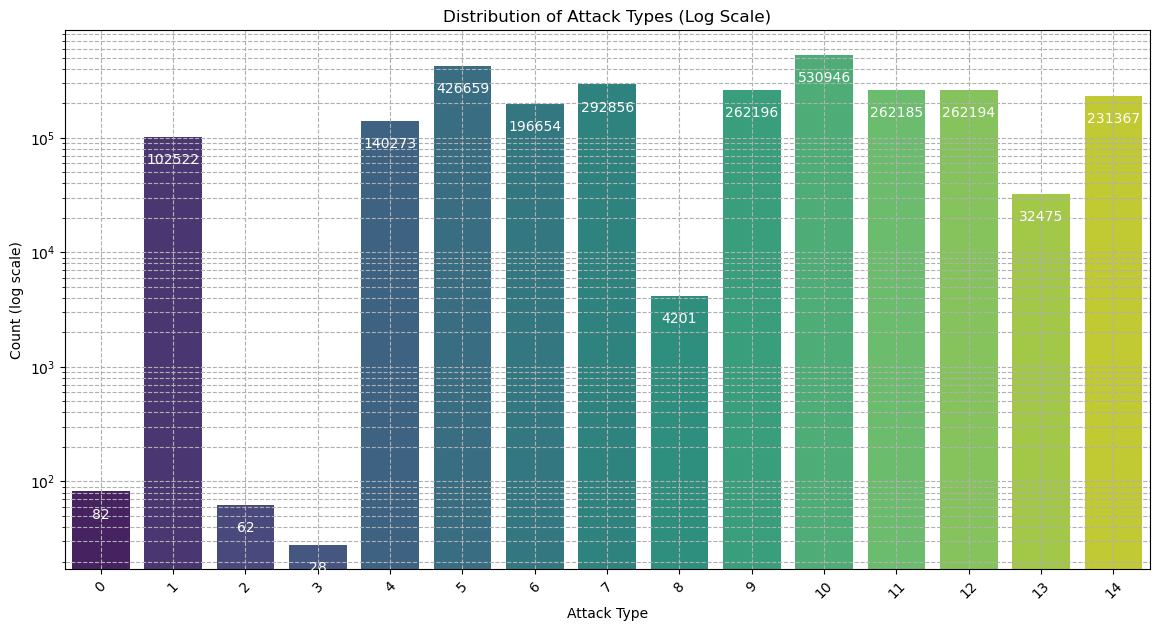

In [5]:
# Improved Plot distribution of 'Attack' column
plt.figure(figsize=(14, 7))

attack_counts = data['label_mul'].value_counts()
colors = sns.color_palette('viridis', len(attack_counts))

ax = sns.barplot(x=attack_counts.index, y=attack_counts.values, palette=colors)
plt.yscale('log')
plt.title('Distribution of Attack Types (Log Scale)')
plt.xlabel('Attack Type')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=45)
plt.grid(True, which="both", ls="--")

for p in ax.patches:
    ax.annotate(f'\n{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='top', color='white', size=10)

plt.show()

In [6]:
print(f'Unique attack values and their counts:\n{data["label_mul"].value_counts()}')


Unique attack values and their counts:
label_mul
10    530946
5     426659
7     292856
9     262196
12    262194
11    262185
14    231367
6     196654
4     140273
1     102522
13     32475
8       4201
0         82
2         62
3         28
Name: count, dtype: int64


In [9]:
X_train, X_test = train_test_split(data_scaled, test_size=0.2, random_state=42)

In [10]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

In [11]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.85) + 1  # For 85% variance

In [12]:
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [13]:
print("Original Training Data Shape:", X_train.shape)
print("Reduced Training Data Shape (PCA):", X_train_pca.shape)
print("Number of Components Selected:", n_components)

Original Training Data Shape: (438257, 70)
Reduced Training Data Shape (PCA): (438257, 12)
Number of Components Selected: 12


In [56]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Load your dataset
dataset = pd.read_csv('./data/cleaned_merged_data.csv')
data = dataset.copy()

# Prepare features and labels
X = data.drop(columns=['Attack_Num']).values  # Features
y = data['Attack_Num'].values  # Labels

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for feature reduction
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Create a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Function to create non-IID data partitions
def create_noniid_data(X, y, num_clients, alpha):
    client_data = [[] for _ in range(num_clients)]
    unique_classes = np.unique(y)

    for i in range(num_clients):
        proportions = np.random.dirichlet(np.ones(len(unique_classes)) * alpha)
        for j, proportion in enumerate(proportions):
            class_indices = np.where(y == unique_classes[j])[0]
            num_samples = int(proportion * len(class_indices))
            selected_indices = np.random.choice(class_indices, num_samples, replace=False)
            client_data[i].extend(zip(X[selected_indices], y[selected_indices]))

    return client_data

# Create non-IID data for 10 clients
client_data = create_noniid_data(X_pca, y, num_clients=10, alpha=0.5)

# Create datasets for each client
client_datasets = [CustomDataset(np.array([data[0] for data in client]), np.array([data[1] for data in client])) for client in client_data]

In [11]:
import matplotlib.pyplot as plt

In [12]:
# Assuming 'Attack_Num' is the target variable and you want to exclude it
features = data.drop(columns=['Attack_Num'])  # Adjust as necessary

In [13]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [14]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

In [15]:
pca_df = pd.DataFrame(data=features_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Attack_Num'] = data['Attack_Num'].values  # Add the target variable

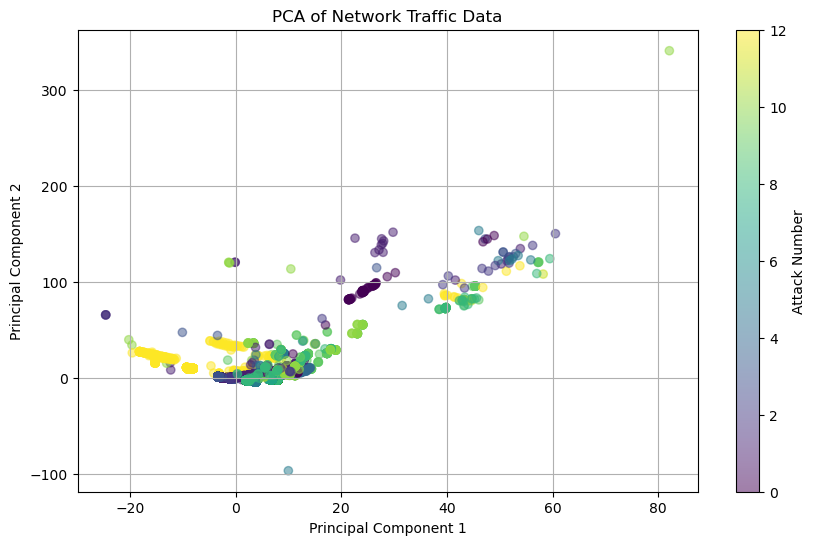

In [16]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], 
                       c=pca_df['Attack_Num'], cmap='viridis', alpha=0.5)

# Add a color bar
plt.colorbar(scatter, label='Attack Number')
plt.title('PCA of Network Traffic Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()